# Exercise 6: Customer segmentation

The data set and the description of the data set can be found here: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

I have copied some information here:

## Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

## There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).

The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

## Attribute Information:

### Input variables:
#### bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Exercises

1. Load the Bank Marketing Data Set and preprocess the data. You can remove any missing values, normalize the numerical features, and encode the categorical features.
2. Visualise the data set using scatter plots or other visualization techniques.
3. Use k-means clustering to cluster the Bank Marketing Data Set into different groups. Vary the number of clusters and evaluate the performance of the clustering using metrics such as the within-cluster sum of squares (WCSS) and silhouette coefficient. What is a good level of $k$?
4. Visualize the clusters using scatter plots or other visualization techniques. You can use the PCA again to reduce the dimensionality of the data set and plot the first two principal components.
5. Interpret the clusters and identify any patterns or insights in the data set. For example, you could investigate whether certain groups of customers are more likely to subscribe to a term deposit and identify the key features that distinguish these customers from others.

In [3]:
# Exercise 1

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the data set
df = pd.read_csv('../../data/bank_marketing_data_set/bank/bank.csv', delimiter=';')

# Remove missing values
df.dropna(inplace=True)

# Normalize the numerical features
scaler = StandardScaler()

df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']] = scaler.fit_transform(df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']])

# Encode the categorical features
encoder = LabelEncoder()
df['job'] = encoder.fit_transform(df['job'])
df['marital'] = encoder.fit_transform(df['marital'])
df['education'] = encoder.fit_transform(df['education'])
df['default'] = encoder.fit_transform(df['default'])
df['housing'] = encoder.fit_transform(df['housing'])
df['loan'] = encoder.fit_transform(df['loan'])
df['contact'] = encoder.fit_transform(df['contact'])
df['month'] = encoder.fit_transform(df['month'])
df['poutcome'] = encoder.fit_transform(df['poutcome'])
df['y'] = encoder.fit_transform(df['y'])

# Print the first five rows of the preprocessed data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,-1.056270,10,1,0,0,0.121072,0,0,0,0.374052,10,-0.711861,-0.576829,-0.407218,-0.320413,3,0
1,-0.772583,7,1,1,0,1.118644,1,1,0,-0.596026,8,-0.169194,-0.576829,2.989044,2.041734,0,0
2,-0.583458,4,2,2,0,-0.024144,1,0,0,0.010273,0,-0.303898,-0.576829,2.899143,0.270124,0,0
3,-1.056270,4,1,2,0,0.017726,1,1,2,-1.566105,6,-0.250017,0.387967,-0.407218,-0.320413,3,0
4,1.686036,1,1,1,0,-0.472753,1,0,2,-1.323585,8,-0.146102,-0.576829,-0.407218,-0.320413,3,0


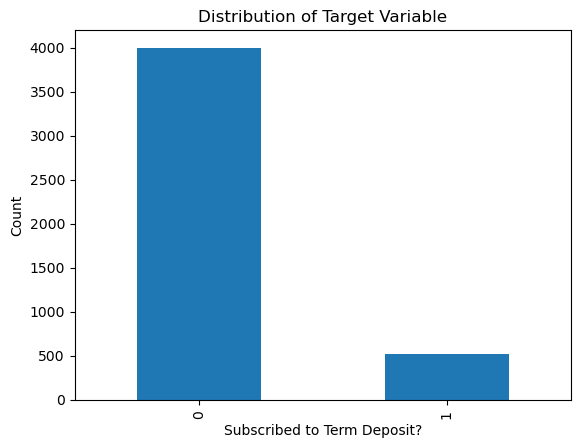

In [4]:
# Exercise 2

import matplotlib.pyplot as plt

# Plot a bar chart of the target variable
df['y'].value_counts().plot(kind='bar')
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

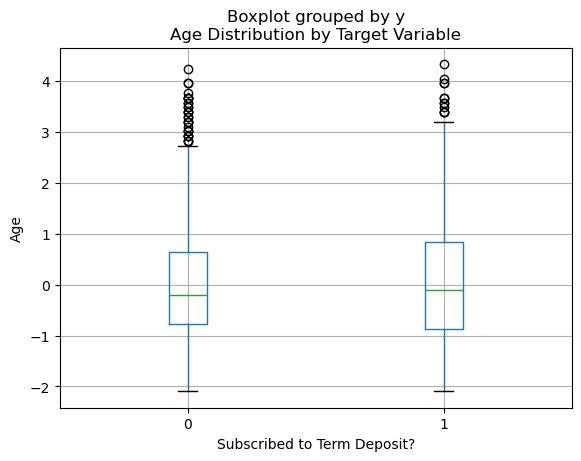

In [5]:
# Plot a box plot of age by target variable
df.boxplot(column='age', by='y')
plt.title('Age Distribution by Target Variable')
plt.xlabel('Subscribed to Term Deposit?')
plt.ylabel('Age')
plt.show()

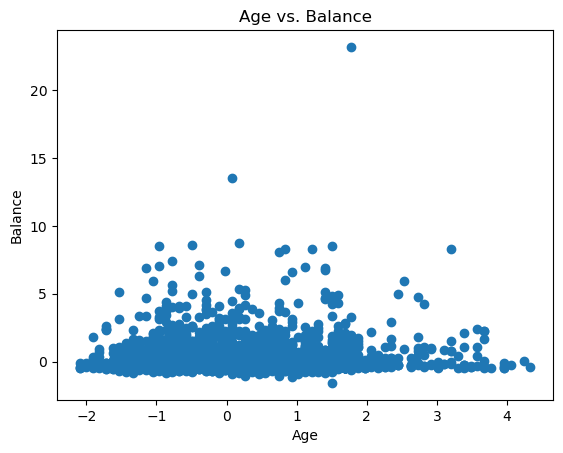

In [6]:
# Plot a scatter plot of age and balance
plt.scatter(df['age'], df['balance'])
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Age vs. Balance')
plt.show()

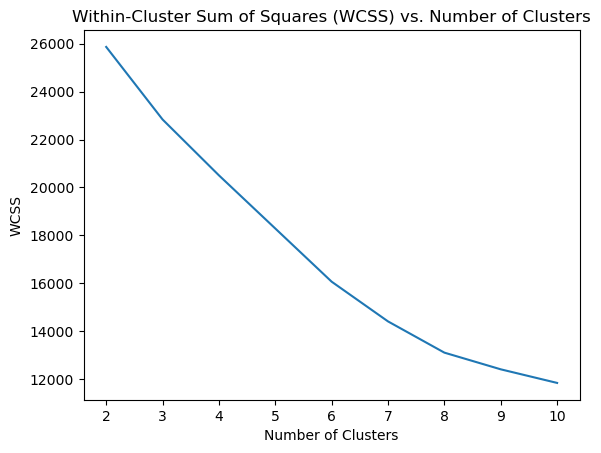

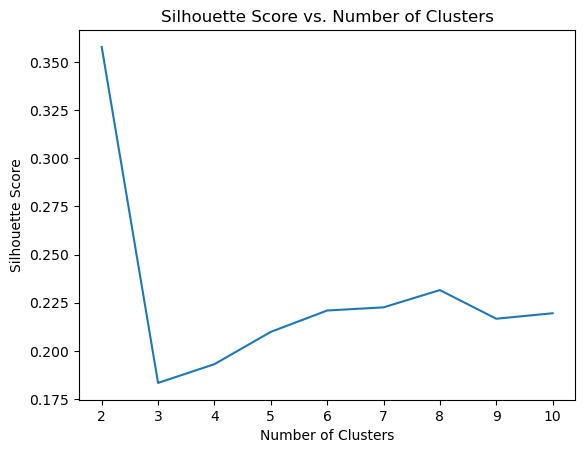

cluster
0    3833
1     688
Name: count, dtype: int64


In [7]:
# Exercise 3

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Subset the data set to include only numerical features
X = df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]

# Vary the number of clusters and evaluate the performance of the clustering
wcss = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualize the performance of the clustering using a plot of WCSS and Silhouette scores
plt.plot(range(2, 11), wcss)
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit the optimal clustering using the chosen number of clusters
k = np.argmax(silhouette_scores) + 2  # Select the number of clusters that maximizes silhouette score
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

# Add the cluster labels to the original data set
df['cluster'] = kmeans.labels_

# Print the number of customers in each cluster
print(df['cluster'].value_counts())

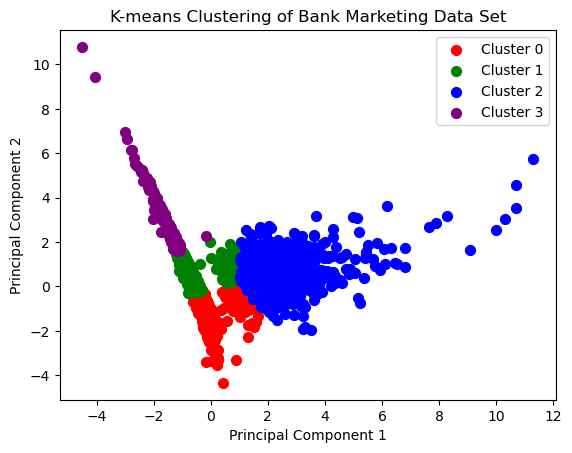

In [8]:
# Exercise 4

from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the data set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit k-means clustering with the optimal number of clusters
k = 4  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_pca)

# Add the cluster labels to the original data set
df['cluster'] = kmeans.labels_

# Visualize the clusters using a scatter plot
colors = ['red', 'green', 'blue', 'purple', 'orange']
for i in range(k):
    plt.scatter(X_pca[df['cluster'] == i, 0], X_pca[df['cluster'] == i, 1], s=50, c=colors[i], label='Cluster ' + str(i))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Bank Marketing Data Set')
plt.legend()
plt.show()

In [9]:
# Exercise 5
df.groupby('cluster')['y'].value_counts(normalize=True)

cluster  y
0        0    0.855539
         1    0.144461
1        0    0.939988
         1    0.060012
2        0    0.800618
         1    0.199382
3        0    0.972527
         1    0.027473
Name: proportion, dtype: float64

In [10]:
# Compute the average values of the numerical features for each cluster
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
mean_values = df.groupby('cluster')[numerical_features].mean()
print(mean_values)

              age   balance       day  duration  campaign     pdays  previous
cluster                                                                      
0        0.153442  0.068749 -0.659782  0.280417 -0.323359 -0.346693 -0.279114
1       -0.134274 -0.096884  0.718939 -0.268572  0.086225 -0.364738 -0.289744
2       -0.070162  0.074887 -0.213693  0.006770 -0.228886  2.139701  1.710413
3       -0.123636 -0.083696  1.015663 -0.485062  3.473197 -0.401785 -0.317168


In [11]:
# Count the number of observations in each cluster
counts = df["cluster"].value_counts()
for i, count in enumerate(counts):
    print(f"Cluster {i+1}: {count} observations")

Cluster 1: 1959 observations
Cluster 2: 1733 observations
Cluster 3: 647 observations
Cluster 4: 182 observations
